In [ ]:
!pip install ucimlrepo



In [ ]:
! pip install git+https://github.com/amazon-science/chronos-forecasting.git


  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-ojpcz1k5
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-ojpcz1k5
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit eb7bdfc047de3e7af972b4ee7cf23a7968b7daa3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12

In [ ]:
from chronos import ChronosPipeline
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [ ]:
# Configuramos el pipeline de Chronos
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",  # Cambiar a "cpu" si no tienes GPU compatible
    torch_dtype=torch.bfloat16,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

##**1. Procesamiento de datos**

In [ ]:
from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)
Xair = air_quality.data.features
yair = air_quality.data.targets

In [ ]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

In [ ]:
# Cambiar el nombre de la variable C6H6(GT)
df = df.rename(columns={'C6H6(GT)': 'C6H6'})

In [ ]:
 #Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [ ]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# Reemplazar los valores -200 en la columna T con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].ffill(inplace=True)
df['T'].ffill(inplace=True)
df['RH'].ffill(inplace=True)

In [ ]:
print(df.head())

                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6


In [ ]:
#Datos historicos para que entrene
context=torch.tensor(df['C6H6'])

<ipython-input-12-389ab8ceca02>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context=torch.tensor(df['C6H6'])


In [ ]:
#Longuitud de prediccion próximas 24 horas
prediction_length = 24

In [ ]:
# Predicciones
forecast = pipeline.predict(context, prediction_length)


In [ ]:
#Crea el index
forecast_index = range(len(df), len(df) + prediction_length)

In [ ]:
#Intervalo de confianza
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

**Gaficos**

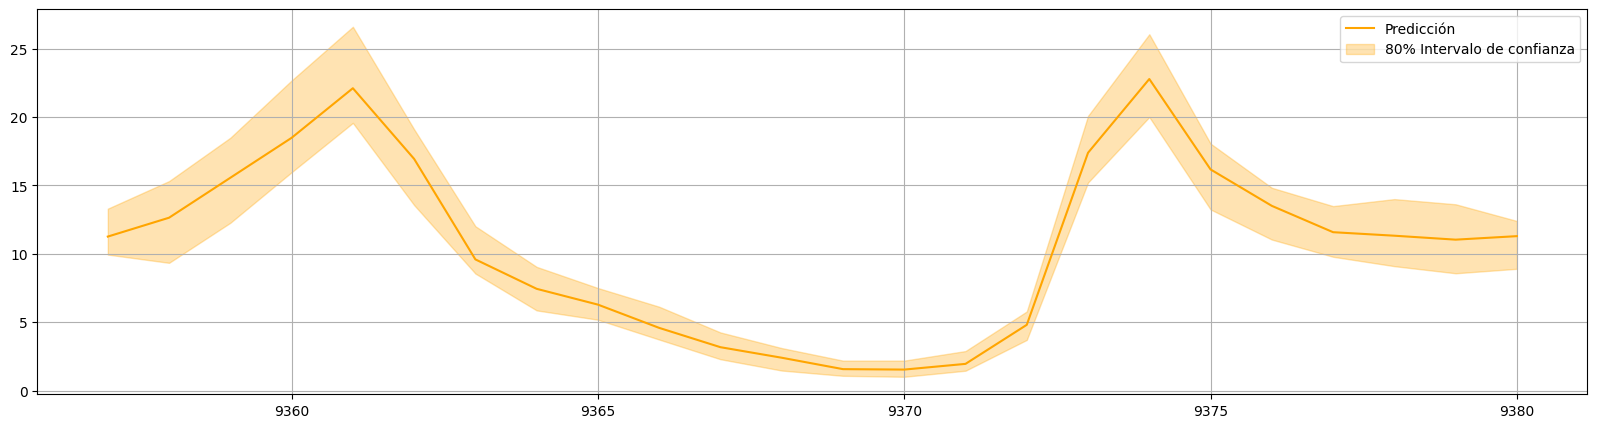

In [ ]:
# Grafico prediccion
plt.figure(figsize=(20, 5))
plt.plot(forecast_index, median, color="orange", label="Predicción")
plt.fill_between(forecast_index, low, high, color="orange", alpha=0.3, label="80% Intervalo de confianza")
plt.legend()
plt.grid()
plt.show()

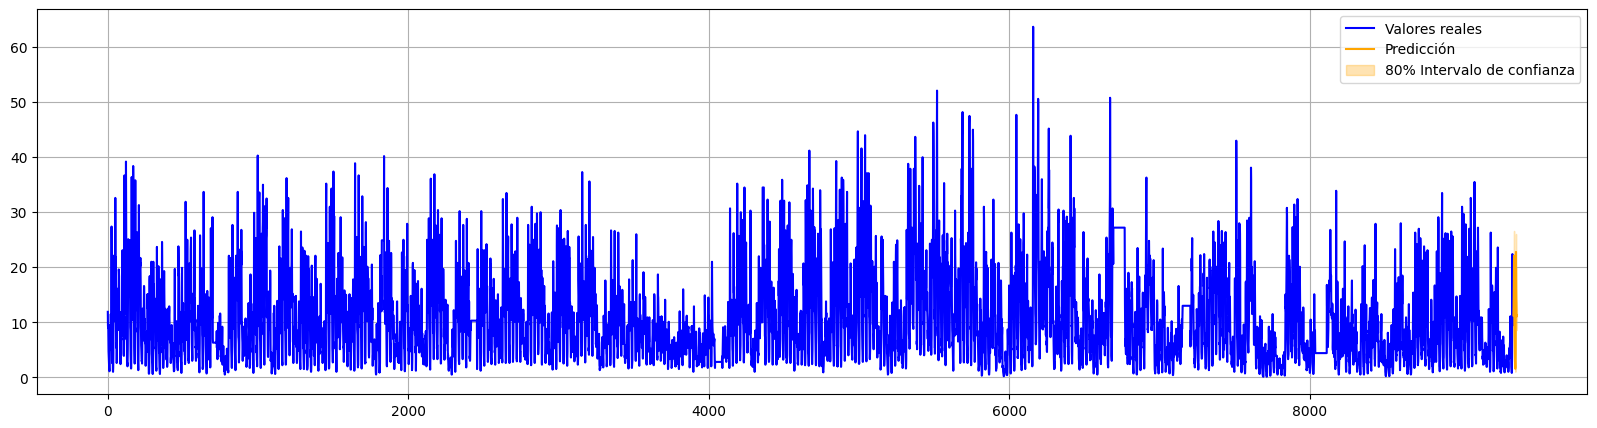

In [ ]:

real_index = range(len(df))  # Índice para la serie real
real_values = df['C6H6'].values  # Valores reales de la serie

# Grafico la serie real y la predicción
plt.figure(figsize=(20, 5))
plt.plot(real_index, real_values, color="blue", label="Valores reales")
plt.plot(forecast_index, median, color="orange", label="Predicción")
plt.fill_between(forecast_index, low, high, color="orange", alpha=0.3, label="80% Intervalo de confianza")
plt.legend()
plt.grid()
plt.show()

**Evaluacion del modelo**

Separar train y test para evaluar modelo, obtener sus métricas y poder compararlo con los otros algoritmos.


In [ ]:
# Separar los datos en train y test

train_size = int(len(df) * 0.80)
train = df['C6H6'][:train_size]
test = df['C6H6'][train_size:]


In [ ]:
train_length = len(train)
test_length = len(test)
print("Longitud de train:", train_length)
print("Longitud de test:", test_length)

In [ ]:
context3=torch.tensor(train)

<ipython-input-67-69374e74d4cf>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context3=torch.tensor(train)


In [ ]:
# Predicciones
forecast3 = pipeline.predict(context3, prediction_length, limit_prediction_length=False)

/usr/local/lib/python3.10/dist-packages/chronos/chronos.py:503: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


El algoritmo sugiere no hacer predicciones mayores a 64 ya que el algoritmo no está optimizado y hay que forzarlo con limit_prediction_length=False.

Para poder evaluar como es la predicciones se compara las ultimas 24 observaciones con las predicciones de 24 horas.

In [ ]:
# Eliminar las últimas 24 observaciones
df2 = df.iloc[:-24, :]

print(df2)

                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6
...                   ...   ...   ...
2005-04-03 10:00:00   3.4  21.1  23.7
2005-04-03 11:00:00   5.3  24.0  19.3
2005-04-03 12:00:00   5.3  26.5  16.4
2005-04-03 13:00:00   3.8  28.7  13.7
2005-04-03 14:00:00   4.2  28.5  13.1

[9333 rows x 3 columns]


In [ ]:
#Datos historicos para que entrene
context2=torch.tensor(df2['C6H6'])

<ipython-input-15-321a9286d7c7>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context2=torch.tensor(df2['C6H6'])


In [ ]:
#Longuitud de prediccion próximas 24 horas
prediction_length = 24

In [ ]:
# Predicciones
forecast2 = pipeline.predict(context2, prediction_length)


In [ ]:
#Crea el index
forecast2_index = range(len(df2), len(df2) + prediction_length)

In [ ]:
#Intervalo de confianza
low, median, high = np.quantile(forecast2[0].numpy(), [0.1, 0.5, 0.9], axis=0)

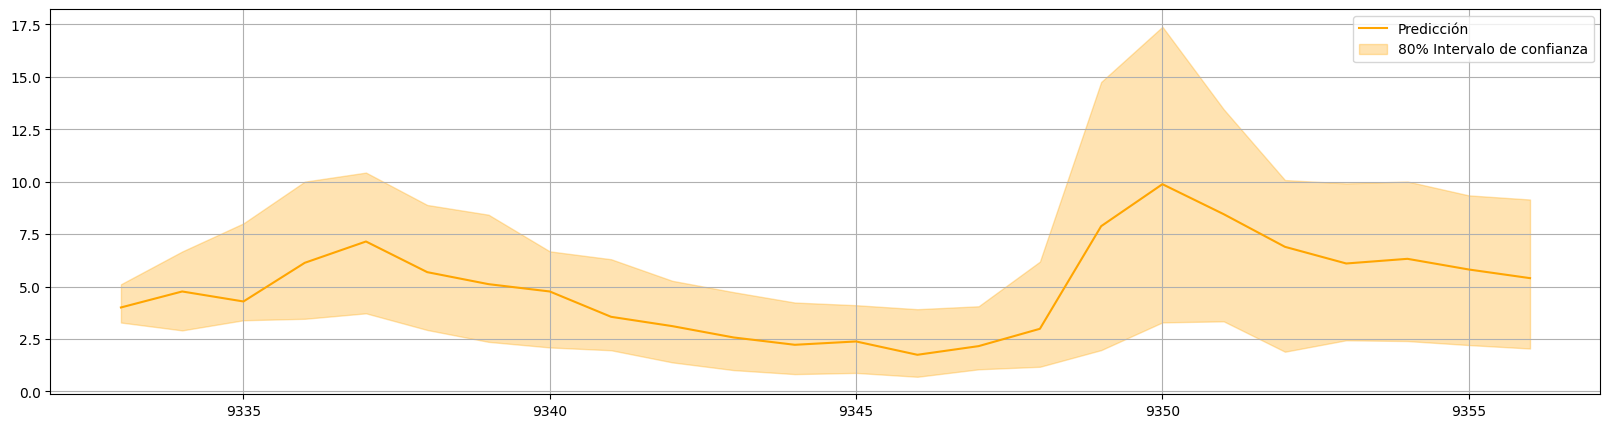

In [ ]:
# Grafico prediccion
plt.figure(figsize=(20, 5))
plt.plot(forecast2_index, median, color="orange", label="Predicción")
plt.fill_between(forecast2_index, low, high, color="orange", alpha=0.3, label="80% Intervalo de confianza")
plt.legend()
plt.grid()
plt.show()

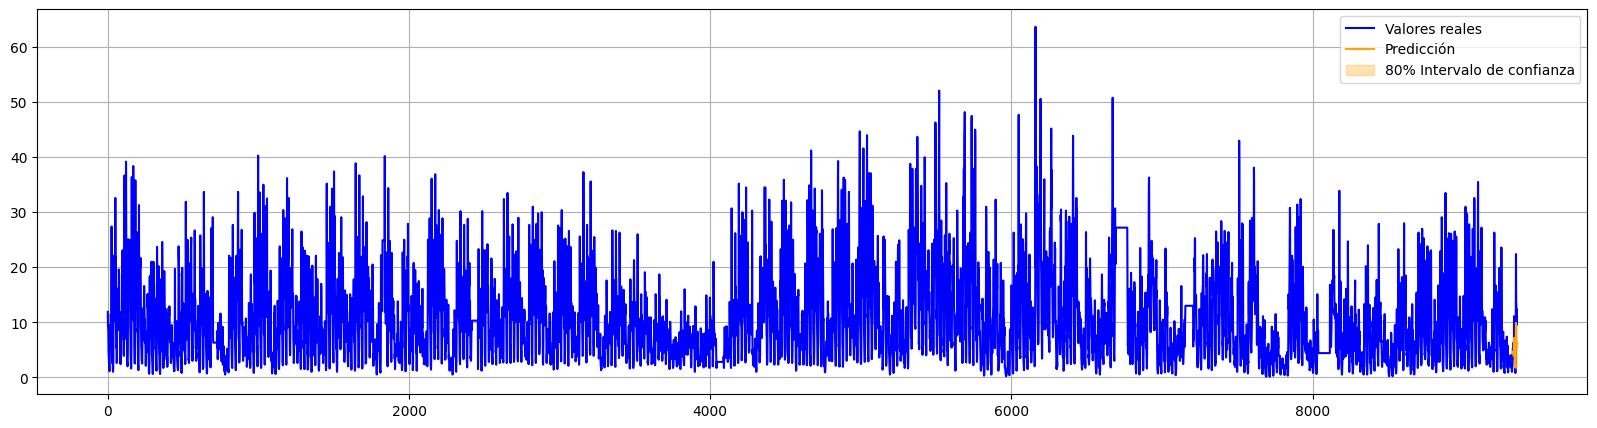

In [ ]:
real_index = range(len(df))  # Índice para la serie real
real_values = df['C6H6'].values  # Valores reales de la serie

# Grafico la serie real y la predicción
plt.figure(figsize=(20, 5))
plt.plot(real_index, real_values, color="blue", label="Valores reales")
plt.plot(forecast2_index, median, color="orange", label="Predicción")
plt.fill_between(forecast2_index, low, high, color="orange", alpha=0.3, label="80% Intervalo de confianza")
plt.legend()
plt.grid()
plt.show()

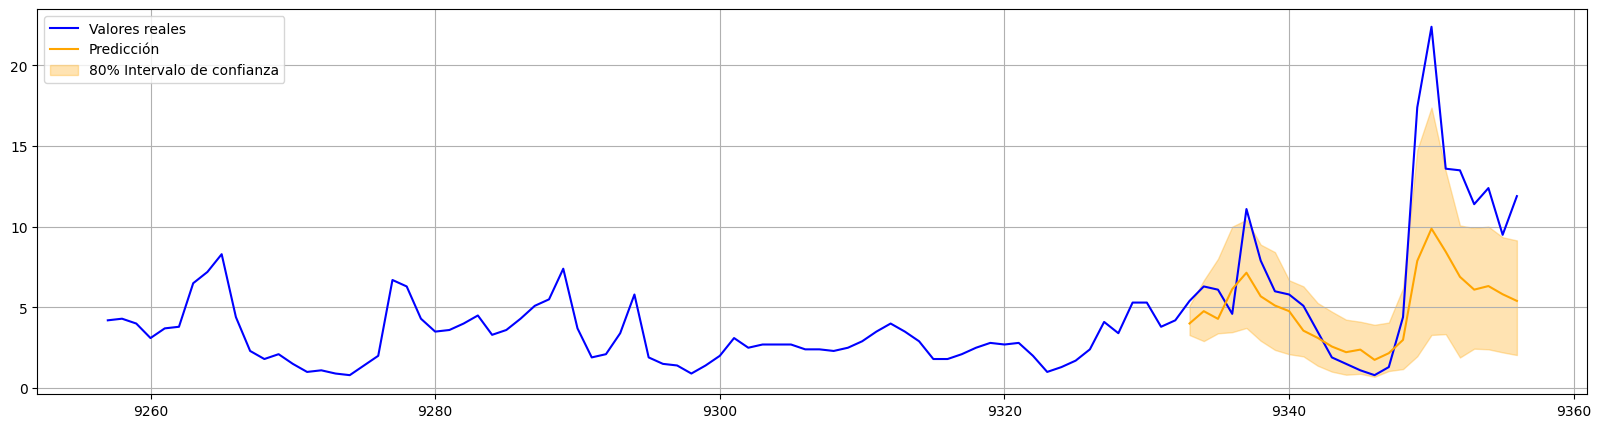

In [ ]:
# Índice y valores para las últimas 100 observaciones de la serie real
real_index_ultimas_100 = range(len(df) - 100, len(df))
real_values_ultimas_100 = df['C6H6'].values[-100:]

# Ajustar también forecast2_index, median, low, high a las últimas 100 observaciones si es necesario
# Ejemplo: forecast2_index_ultimas_100 = forecast2_index[-100:] (modifica si tus predicciones son para las últimas 100 horas)

# Grafico la serie real y la predicción para las últimas 100 observaciones
plt.figure(figsize=(20, 5))
plt.plot(real_index_ultimas_100, real_values_ultimas_100, color="blue", label="Valores reales")
plt.plot(forecast2_index[-100:], median[-100:], color="orange", label="Predicción")
plt.fill_between(forecast2_index[-100:], low[-100:], high[-100:], color="orange", alpha=0.3, label="80% Intervalo de confianza")
plt.legend()
plt.grid()
plt.show()

Se observa que la prediccion no es tan buena ya que las observaciones reales escapan del intervalo de confianza de las predicciones.